# Analysis of Biodiversity in National Parks

In this project, I analyze data from the National Parks Service pertaining to endangered species in various parks. I examine concepts such as conservation status, risk of endangerment, variation between species and their endangerment, and most commonly observed species.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Examine the Data

In [2]:
# contains data about species and conservation status
spe= pd.read_csv('species_info.csv')

# contains data about recorded sightings at various parks over a seven-day period
obs= pd.read_csv('observations.csv')

In [3]:
# examine the columns
print(spe.columns)
print(obs.columns)

Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object')
Index(['scientific_name', 'park_name', 'observations'], dtype='object')


In [4]:
# examine the head for DataFrame spe
print(spe.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  


In [5]:
# examine the head for DataFrame obs
print(obs.head())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85


In [6]:
# see the value counts for species categories
print(spe.category.value_counts())

Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: category, dtype: int64


We can see that the vast majority of species in the dataset are vascular plants.

## What is the distribution of conservation statuses?

Before plotting the distribution of conservation statuses, we first do some basic exploratory data analysis by looking at the number of unique conservation status values, as well as what those values are.

In [7]:
# 
print(spe.conservation_status.nunique())

4


In [8]:
print(spe.conservation_status.unique())

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


We see that one of the conservation status values is nan. Let's find the total number of nan's for this column.

In [9]:
print(len(spe.conservation_status))
print(spe.conservation_status.isna().sum())

5824
5633


For the purposes of this project, species with a conservation status of nan are classified as Least Concern (LC) or do not have a conservation status assigned.

In [10]:
spe.fillna('No Intervention', inplace=True)

In [11]:
con= spe[spe.conservation_status != 'No Intervention']
con= con.reset_index(drop=True)
print(type(con))

<class 'pandas.core.frame.DataFrame'>


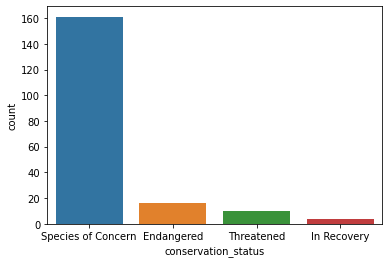

In [12]:
ax= sns.countplot(x='conservation_status',
             data=con)

We can see from our distribution of conservation statuses that "Species of Concern" is the status assigned to the highest number of species. 

#### Distribution of category counts by conservation status

The following stacked bar chart shows the breakdown of categories for each conservation status.

In [13]:
con= con.groupby(["conservation_status", "category"])

In [14]:
con= con['scientific_name'].count().unstack()

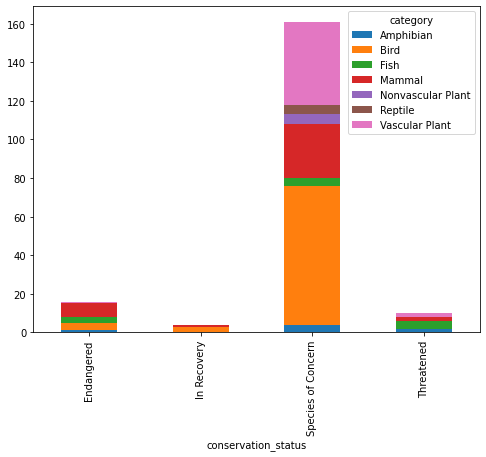

In [15]:
ax= con.plot(kind='bar',
             figsize=(8,6),
             stacked=True)

## Are certain categories of species more likely to be endangered?

First, we create a new column to track whether a species is protected or not.

In [16]:
spe['is_protected']= spe.conservation_status != 'No Intervention'

In [17]:
print(spe.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  \
0                           Gapper's Red-Backed Vole     No Intervention   
1                              American Bison, Bison     No Intervention   
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...     No Intervention   
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
4                                      Wapiti Or Elk     No Intervention   

   is_protected  
0         False  
1         False  
2         False  
3         False  
4         False  


In [18]:
# group by category (Mammal, etc.) then by Protection status (True or False)
# get the count of Protection status by category
prot= spe.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns='is_protected',
                                    index='category',
                                    values='scientific_name').reset_index()
prot.columns= ['category', 'not_protected', 'protected']
print(prot)

            category  not_protected  protected
0          Amphibian             72          7
1               Bird            413         75
2               Fish            115         11
3             Mammal            146         30
4  Nonvascular Plant            328          5
5            Reptile             73          5
6     Vascular Plant           4216         46


In [19]:
# get the raw percentages of protected species by category
prot.protected / prot.not_protected

0    0.097222
1    0.181598
2    0.095652
3    0.205479
4    0.015244
5    0.068493
6    0.010911
dtype: float64

We can see that the categories with the highest raw percentage of protected species are mammals, birds, and amphibians. In terms of raw numbers, bird, mammals, and vascular plants have the highest number of protected species.

To determine if there is a significant difference in the endangerment between mammals and birds (i.e. one category is statistically "more endangered" than the other), we can use the contingency table below to run a chi-squared test.

In [20]:
prot.iloc[[1, 3]]

,category,not_protected,protected
1,Bird,413,75
3,Mammal,146,30


In [21]:
conting1= [[413, 75],
          [146, 30]]

In [22]:
from scipy.stats import chi2_contingency

In [23]:
chi2_contingency(conting1)

(0.16170148316545574,
 0.6875948096661336,
 1,
 array([[410.8313253,  77.1686747],
        [148.1686747,  27.8313253]]))

The p-value of 0.69 is well above the threshold of significance of 0.05. We can conclude that neither birds nor mammals are more endangered than the other.

Next, let's look at the contingency table for mammals and reptiles:

In [24]:
prot.iloc[[3, 5]]

,category,not_protected,protected
3,Mammal,146,30
5,Reptile,73,5


Again, we perform a chi-squared test to determine if mammals are more endangered than reptiles.

In [25]:
conting2= [[146, 30],
          [73, 5]]

In [26]:
chi2_contingency(conting2)

(4.289183096203645,
 0.03835559022969898,
 1,
 array([[151.7480315,  24.2519685],
        [ 67.2519685,  10.7480315]]))

The p-value of 0.038 is comfortably below the threshold of 0.05 for significance. We can conclude that mammals in this dataset are more endangered than reptiles. Tests of this sort can be performed on any pair of categories to determine if there is a significant difference in their endangerment.

## Which species was spotted the most at each park?

To find out which species was observed the most times at each park, we can split the dataset based on park name, then calculate the max value in the observations column for each park.

In [27]:
bryce= obs[obs.park_name == 'Bryce National Park']
great= obs[obs.park_name == 'Great Smoky Mountains National Park']
yello= obs[obs.park_name == 'Yellowstone National Park']
yosem= obs[obs.park_name == 'Yosemite National Park']

In [28]:
bryce= bryce[bryce.observations == bryce.observations.max()]

great= great[great.observations == great.observations.max()]

yello= yello[yello.observations == yello.observations.max()]

yosem= yosem[yosem.observations == yosem.observations.max()]

In [29]:
pd.concat([bryce, great, yello, yosem])

,scientific_name,park_name,observations
13138,Valerianella radiata,Bryce National Park,176
8840,Sonchus asper ssp. asper,Great Smoky Mountains National Park,147
11281,Lycopodium tristachyum,Yellowstone National Park,321
6682,Ivesia shockleyi var. shockleyi,Yosemite National Park,223
